# BMGF TTS Evaluation
* This notebook utilizes abstracted classes from **MeaslesModelEval.py** to demonstrate the process for training and evaluating the performance of ML libraries by country and predictor variables.
* Each model is initiated by model class using a minimum of a country, a dependent variable, and a dictionary of independent variables and their associated predictor lags.
* All models default to witholding the last 12 months of data as the test set, though alternate values may be passed as needed.
  

## Methods and globals

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import MeaslesDataLoader as md
import MeaslesModelEval as mm
import EpiPreprocessor as ep

%matplotlib inline

129/194 included countries found with noted outbreaks.


## Load / refresh local preprocessor config
* The **EpiPreprocessor.py** preprocessor module enables a standardized set of preproccessor transformations to be applied to any data set fed to a training run.
* Preprocessor configs may be stored as either publicly available google sheets, local csv files, or web accessible csv files.
* When any preprocessor config is loaded, a copy is saved to *input/TempConfig.csv*.
* Each model defaults to *input/TempConfig.csv* if no preprocessor location is passed.
* In practice, you need only load the remote config once after each remote change.
* Each method preprocessor method is applied in space separated, left to right order.

In [2]:
defaultConfigURL = 'https://docs.google.com/spreadsheets/d/1zn0e2-hi-p9hcOWiMk03v4TH_zq64BfD9pUgbAf1uRs/edit?usp=sharing'
preprocessorConfig = ep.getGoogleSheetConfig(defaultConfigURL)

## Preprocessor data structure & usage:
* Preprocessor arguments are stored as a list of operations by input data columns.
* For each simulation run, preprocessors are only applied for variables which are found and used, so extensive sets may be passed without issue.
* Data with no preprocessor routine assigned will be passed unchanged, though one may also assign a routine of "pass_unchanged" for clarity.
* In cases where a user desires to pass additional preprocessor arguments for a single model run, one may assign a properly formatted dictionary to the variable **additionalPrep** when initializing a run.
* Preprocessor arguments passed via **additionalPrep** will be executed after operations present in the primary preprocessor config.

In [3]:
{key:value for key, value in list(preprocessorConfig.items())[:10]}

{'ds': ['pass_unchanged'],
 'population_jan': ['january_only', 'interpolate_via_linear'],
 'population_july': ['july_only', 'interpolate_via_linear'],
 'birth_per_1k': ['january_only', 'divide_by_12', 'interpolate_via_linear'],
 'births': ['january_only', 'divide_by_12', 'interpolate_via_linear'],
 'migrations': ['january_only', 'divide_by_12', 'interpolate_via_linear'],
 'migrations_per_1k': ['january_only',
  'divide_by_12',
  'interpolate_via_linear'],
 'ID_OWN_1524_ZS': ['average_valid_overwrite'],
 'ID_OWN_25UP_ZS': ['average_valid_overwrite'],
 'ID_OWN_BRTH_ZS': ['average_valid_overwrite']}

## Initial data load
* All data loading and formatting is standardized by the module **MeaslesDataLoader.py**.
* The data loader expects prepared data to be placed in *input/processed_measles_model_data.csv'*, though alternate locations may be passed as an argument.
* A Google keyword trends csv is also expected at *input/CountryMeasles2010-2024.csv*, though ignored if not found.

In [4]:
preppedCountries = md.prepData()

129/194 included countries found with noted outbreaks.


# Model execution
The following examples demonstrate a range of ML models, countries, and datatypes. These examples do not represent final methods, predictions, or predictor variable configurations for any given country, only the substantive componenets of the pipeline by which these shall be determined.


## Initialization
* Initializing a model will prepare the underlying data structures, apply preproccessor routines, construct the train and test sets, and discard missing/single value.

#### Syntax: 

*run == mm.npLaggedTTS(args)*

#### Required inputs:
* **country** - str: ISO3 code for the country within **preppedCountries**
* **depVar** - str: dependent variable column to be forecasted from **preppedCountries**
* **indepVars** - {str:int}: dictionary of predictor variable column names and lag period to be applied 

#### Optional inputs:
* **projectionMethod** - str: method by which predictor variables are forward projected, currently only accepts 'NeuralProphet autoregression'
* **testSize** - int: number of months of data to withold as the test set at the end of a country's records for **depVar**
* **randomState** - int: random seed to apply when training a model, defaults to **1337**
* **preprocessor** - str: location of preprocessor config (url or loca)
* **additionalPrep** - {str: [str, ...]}: dictionary of additional preprocessor routines to apply
* **modelArgs** - {str: module}: dictionary of a name and a loaded ML library following SciKit-Learn conventions, used only for the **SKL Generic class**

## Training
* Training a model will train the given predictor on the train set and project the predictor over both the train and test sets.
* Predictor variables are forward projecting using the library passed via **projectionMethod** and cached.
* Each training run is uniquely identified by an MD5 hash of its arguments and data, stored as **run.hash**.
* When an ML model is successfully trained, the model in memory is cached as a python pickle at 'store/{**run.hash**}Trained.pkl'.
* When training is attempted, the module will first look for a cached model for the given run and will load the previous run instead.
* In practice, changes to external libraries (**NeuralProphet, Pandas, SciKit-Learn**, etc) or mechanistic changes to the model may cause these pickles to load incorrectly or otherwise misrepresent the expected results. Care should be taken to periodically empty 'store' after such changes.

#### Syntax:
*run.train()

## Evaluation:
* The evaluation method used SciKit-Learn metrics to calculate the R^2, MAE, and MSE for trained model against the test and train sets respectively.
* Results are returned as a dictionary.
* Additional, a user may plot any trained run via the **plotTTS** method from **MeaslesModelEval**.


## NeuralProphet lagged regressors class
* Uses the **NeuralProphet** library by Meta to forecast variables using a combination of multiple regression, autoregression, seasonal decomposition, and lagged/future regressors.
* **NeuralProphet** evaluates lagged regressors at each time point (monthly here) over the span of the lag, effectively treating {n, n-1, ... 0} as separate components.
* **NeuralProphet** is somewhat biased to expect seasonality and may perform worse for countries with more sporadic outbreak histories.
  * **SeasonalityMetrics.py** contains metrics to address model selection in future versions.
* Likewise, **NeuralProphet** may predict negative cases if strong divergence in seasonal highs occurs.

{'Test MSE': 20.179751931386967,
 'Test MAE': 2.3222313673042128,
 'Test R2': -0.12883423774043057,
 'Train MSE': 100.33387855041697,
 'Train MAE': 4.582162241477495,
 'Train R2': 0.36031050352138616,
 'method': 'NeuralProphet lagged regressors',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'mean_precip_mm_per_day': 3},
 'withheld': 12,
 'random state': 1337,
 'model args': '{}'}

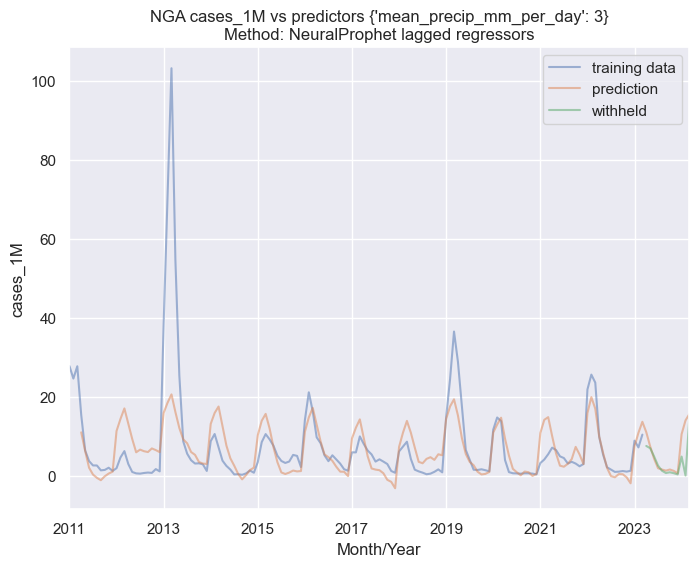

In [5]:
neuralRun = mm.npLaggedTTS('NGA',
                           'cases_1M',
                           indepVars = {'mean_precip_mm_per_day': 3},
                           testSize = 12)

neuralRun.train()
mm.plotTTS(neuralRun)
neuralRun.evaluate()

## NeuralProphet future regressors class
* Same as the lagged regressors class, but in this case regressor lags are applied externally and passed as future regressors to **NeuralProphet** for only the singular int period passed.
* The same lagged regressor method is presently applied in all classes excepting the prior lagged regressors class.

{'Test MSE': 21.460349641216894,
 'Test MAE': 2.5686660928404326,
 'Test R2': -0.20046953556485958,
 'Train MSE': 98.13038237492594,
 'Train MAE': 4.487735610468134,
 'Train R2': 0.37435913175501034,
 'method': 'NeuralProphet future regressors',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'mean_max_temp': 0, 'mean_precip_mm_per_day': 3},
 'withheld': 12,
 'random state': 1337,
 'model args': '{}'}

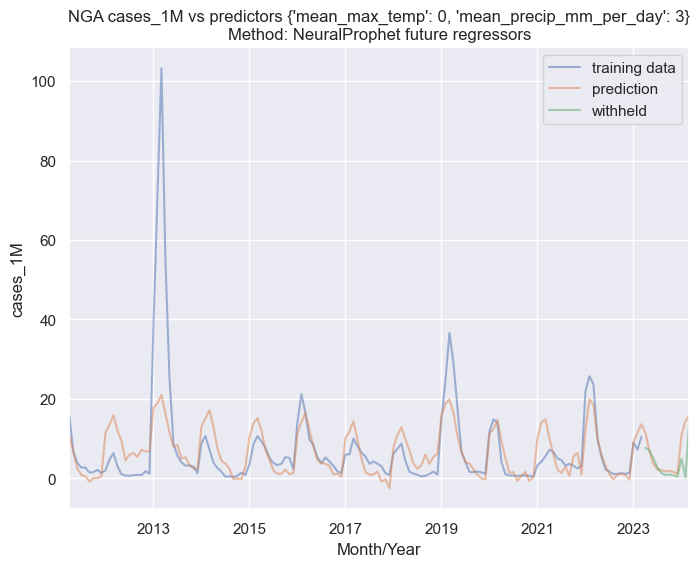

In [6]:
neuralRun = mm.npFutureTTS('NGA',
                           'cases_1M',
                           indepVars = {'mean_precip_mm_per_day':3,
                                       'mean_max_temp':0},
                           testSize = 12)

neuralRun.train()
mm.plotTTS(neuralRun)
neuralRun.evaluate()

## Scikit-learn gradient boosting regression trees class
* Directly implements the **Gradient Boosting Regression** method from **SciKit-Learn**.
* Can be considered timeless as there is no sense of a transmission model, autoregression, or other interaction between predicted states and past states.
  

{'Test MSE': 102.84159372711066,
 'Test MAE': 5.149824468597399,
 'Test R2': -0.09422744432363395,
 'Train MSE': 0.27052214354493376,
 'Train MAE': 0.3802050172317966,
 'Train R2': 0.9867326981057416,
 'method': 'Scikit-learn gradient boosted regression',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'birth_per_1k': 3,
  'mean_max_temp': 3,
  'total_precip_mm_per_day': 3},
 'withheld': 12,
 'random state': 1337,
 'model args': '{}'}

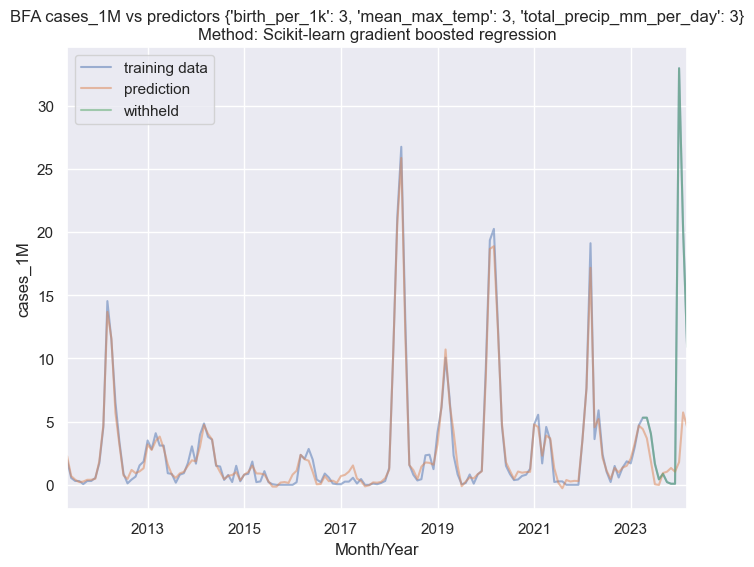

In [7]:
gbrRun = mm.sklGradientBoostingRegression('BFA',
                                          'cases_1M',
                                          indepVars = {'total_precip_mm_per_day':3,
                                                      'birth_per_1k':3,
                                                      'mean_max_temp':3},
                                          testSize = 12)

gbrRun.train()
mm.plotTTS(gbrRun)
gbrRun.evaluate()

## Scikit-learn generic regression wrapper class
* The **sklGeneric** method enables a user to pass any pythonic ML model that follows a **model.init(randomSeed), model.train(numpy array), model.predict(numpy array)**.
* Care should be taken to assign unique names to the **modelName** passed to **modelArgs** as this is used in run hashing.
* In this case, a shortened span of avaialable data is used as the preprocessor back truncated predictor variables that did not cover the extent of the available case data.

{'Test MSE': 106.77902178251293,
 'Test MAE': 5.300363459691518,
 'Test R2': -0.14967678411578,
 'Train MSE': 2.7628986807189095,
 'Train MAE': 1.3882035563238877,
 'Train R2': 0.8738453973410908,
 'method': 'Scikit-learn generic: AdaBoost regressor',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'mnths_since_outbreak_20_per_M': 3,
  'total_precip_mm_per_day': 3},
 'withheld': 12,
 'random state': 1337,
 'model args': "{'model': <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, 'modelName': 'AdaBoost regressor'}"}

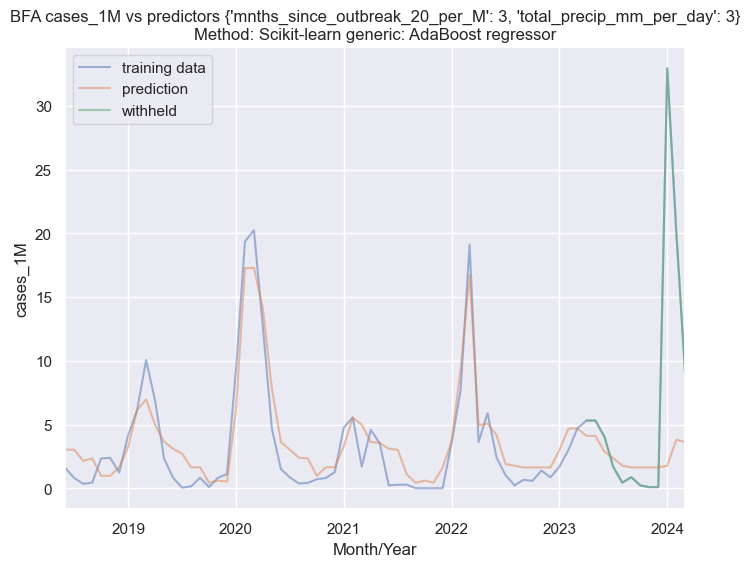

In [8]:
from sklearn.ensemble import AdaBoostRegressor

genericArgs = {'model':AdaBoostRegressor,
             'modelName': 'AdaBoost regressor'}

genericRun = mm.sklGeneric('BFA',
                           'cases_1M',
                           indepVars = {'total_precip_mm_per_day':3,
                                       'mnths_since_outbreak_20_per_M':3},
                           modelArgs = genericArgs,
                           testSize = 12)

genericRun.train()
mm.plotTTS(genericRun)
genericRun.evaluate()

## Ensemble modelling method sweep via skl generic wrapper
* Attempts to project measles cases in Nigeria by each regressor found in **sklearn.ensemble**
* Demonstration of generic wrapper interoperability.

Preparing to run AdaBoostRegressor
Training....
Evaluating...
{'Test MSE': 31.929132304120674, 'Test MAE': 4.797063066842768, 'Test R2': -0.7860822991672018, 'Train MSE': 49.32202932245665, 'Train MAE': 5.721533816307453, 'Train R2': 0.6855420665639702, 'method': 'Scikit-learn generic: AdaBoostRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'AdaBoostRegressor', 'model': <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>}"}


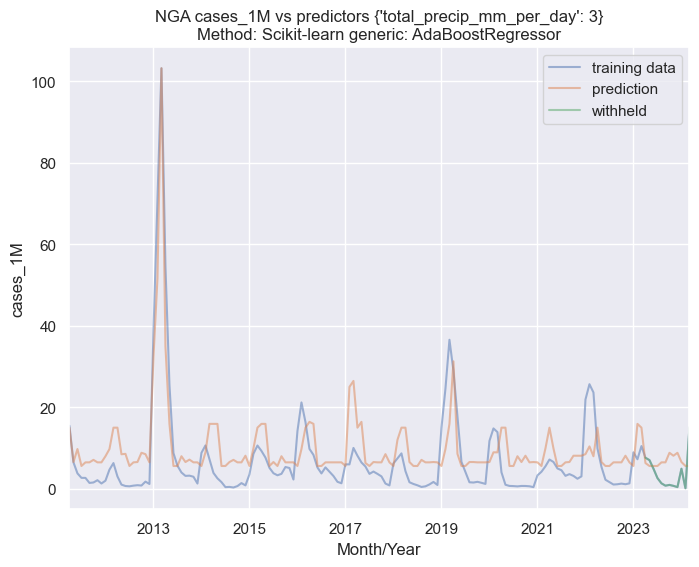


Preparing to run BaggingRegressor
Training....
Evaluating...
{'Test MSE': 16.7314293452766, 'Test MAE': 2.987776790498033, 'Test R2': 0.06406132466341652, 'Train MSE': 35.350933537954546, 'Train MAE': 2.8766044229139327, 'Train R2': 0.7746162990840634, 'method': 'Scikit-learn generic: BaggingRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'BaggingRegressor', 'model': <class 'sklearn.ensemble._bagging.BaggingRegressor'>}"}


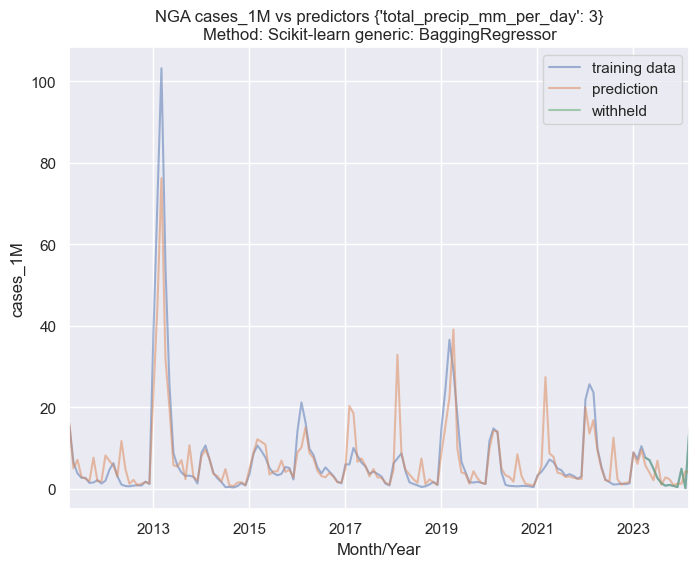


Preparing to run ExtraTreesRegressor
Training....
Evaluating...
{'Test MSE': 16.16543767802131, 'Test MAE': 2.9359257799242084, 'Test R2': 0.09572230713960928, 'Train MSE': 6.100133797914879e-28, 'Train MAE': 9.727943759172161e-15, 'Train R2': 1.0, 'method': 'Scikit-learn generic: ExtraTreesRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'ExtraTreesRegressor', 'model': <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>}"}


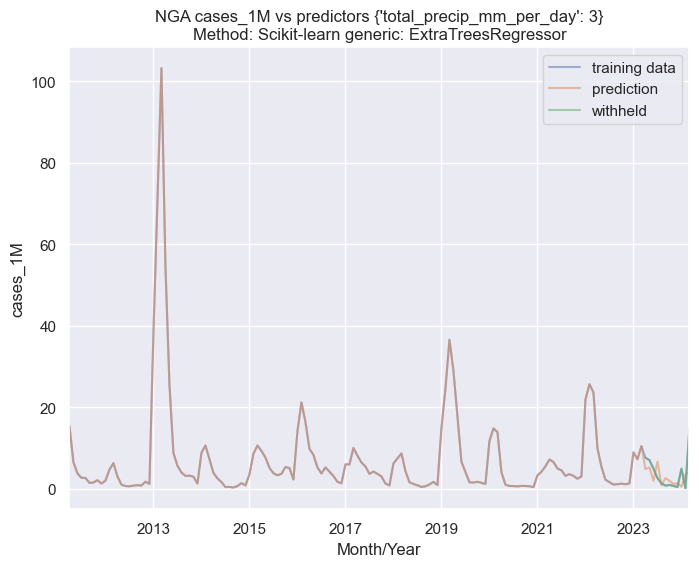


Preparing to run GradientBoostingRegressor
Training....
Evaluating...
{'Test MSE': 15.981109044409644, 'Test MAE': 2.9844828483587142, 'Test R2': 0.10603345830361954, 'Train MSE': 8.504130810452084, 'Train MAE': 2.023072626121766, 'Train R2': 0.9457809940697867, 'method': 'Scikit-learn generic: GradientBoostingRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'GradientBoostingRegressor', 'model': <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>}"}


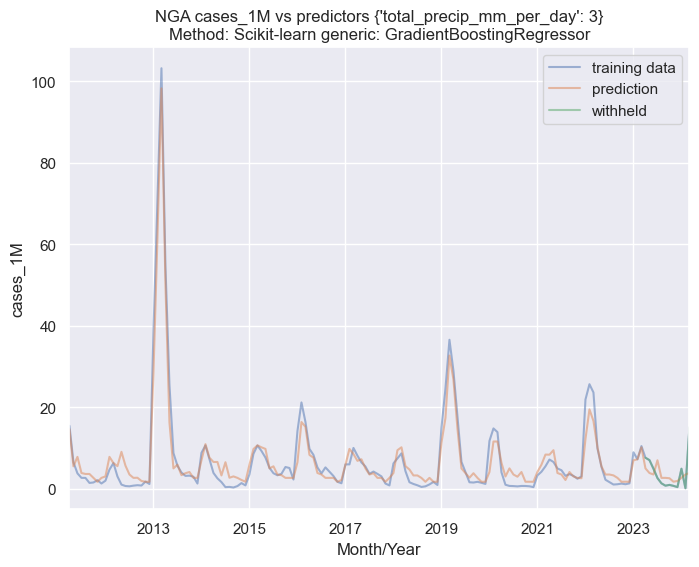


Preparing to run HistGradientBoostingRegressor
Training....
Evaluating...
{'Test MSE': 16.348187881126936, 'Test MAE': 2.916638738330903, 'Test R2': 0.08549945172884554, 'Train MSE': 104.72297003302911, 'Train MAE': 5.065428066971573, 'Train R2': 0.33232737597688566, 'method': 'Scikit-learn generic: HistGradientBoostingRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'HistGradientBoostingRegressor', 'model': <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>}"}


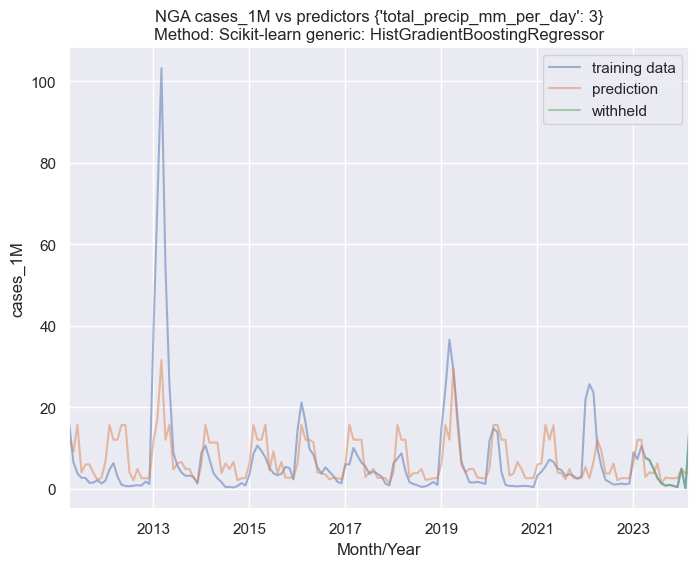


Preparing to run RandomForestRegressor
Training....
Evaluating...
{'Test MSE': 19.10549720569176, 'Test MAE': 3.4794684910732, 'Test R2': -0.06874155084604494, 'Train MSE': 30.953679699126976, 'Train MAE': 2.7599265001454287, 'Train R2': 0.8026514666135914, 'method': 'Scikit-learn generic: RandomForestRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'RandomForestRegressor', 'model': <class 'sklearn.ensemble._forest.RandomForestRegressor'>}"}


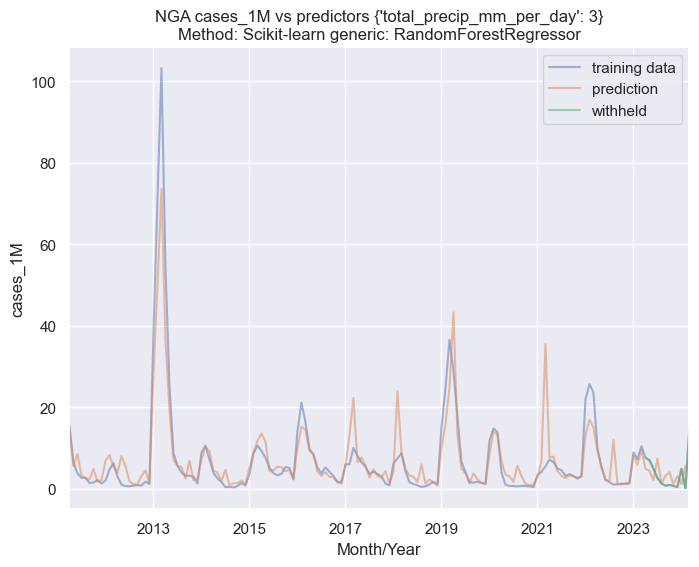


Preparing to run StackingRegressor
Training....
Fails

Preparing to run VotingRegressor
Training....
Fails



,Test MSE,Test MAE,Test R2,Train MSE,Train MAE,Train R2,method,predictor projection,depVar,indepVars,withheld,random state,model args
Model,,,,,,,,,,,,,
AdaBoostRegressor,31.929132,4.797063,-0.786082,4.932203e+01,5.721534e+00,0.685542,Scikit-learn generic: AdaBoostRegressor,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'AdaBoostRegressor', 'model': <c..."
BaggingRegressor,16.731429,2.987777,0.064061,3.535093e+01,2.876604e+00,0.774616,Scikit-learn generic: BaggingRegressor,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'BaggingRegressor', 'model': <cl..."
ExtraTreesRegressor,16.165438,2.935926,0.095722,6.100134e-28,9.727944e-15,1.000000,Scikit-learn generic: ExtraTreesRegressor,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'ExtraTreesRegressor', 'model': ..."
GradientBoostingRegressor,15.981109,2.984483,0.106033,8.504131e+00,2.023073e+00,0.945781,Scikit-learn generic: GradientBoostingRegressor,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'GradientBoostingRegressor', 'mo..."
HistGradientBoostingRegressor,16.348188,2.916639,0.085499,1.047230e+02,5.065428e+00,0.332327,Scikit-learn generic: HistGradientBoostingRegr...,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'HistGradientBoostingRegressor',..."
RandomForestRegressor,19.105497,3.479468,-0.068742,3.095368e+01,2.759927e+00,0.802651,Scikit-learn generic: RandomForestRegressor,NeuralProphet autoregression,cases_1M,{'total_precip_mm_per_day': 3},12,1337,"{'modelName': 'RandomForestRegressor', 'model'..."


In [9]:
import sklearn.ensemble
import inspect
from time import sleep

members = inspect.getmembers(sklearn.ensemble, inspect.isclass)

regressorClasses = [{'modelName':name,
                     'model':cls} for name, cls in members if cls.__module__.startswith('sklearn.ensemble')]

results = []

for regressorModelArgs in regressorClasses:
    sleep(.1)
    modelName = regressorModelArgs['modelName']
    if modelName.endswith('Regressor'):
        try:
            print(f"Preparing to run {modelName}")
            genericRun = mm.sklGeneric('NGA',
                                       'cases_1M',
                                       indepVars = {'total_precip_mm_per_day':3},
                                       modelArgs = regressorModelArgs,
                                       testSize = 12)
        
            print("Training....")
            genericRun.train()
            print("Evaluating...")
            result = genericRun.evaluate()
            print(result)
            mm.plotTTS(genericRun)
            plt.show()
            result['Model'] = modelName
            results.append(result)
        except:
            print("Fails")
            pass
        print()

results = pd.DataFrame(results)
results.set_index(['Model'])

# Command line interface
The CLI is intended to facilitate interoperability with **bash** and **R** scripting but does not support all arguments passed during typical use.

#### Arguments
* **arg 1**: Method
  * Must be one of the following:
     - nplagged (NeuralProphet lagged regressors)
     - npfuture (NeuralProphet future regressors)
     - sklgbr (Scikit-learn gradient boosting regression trees)   
* **arg 2**: country
* **arg 3**: dependent variable
* **arg 4**: independent variables
 * Must be json formatted with not white space characters
     - ex: {'total_precip_mm_per_day':3}
* **arg 5**: output file
* **arg 6**: test size (optional, defaults to 12)

In [10]:
! python MeaslesModelEval.py sklgbr ZWE cases_1M "{'total_precip_mm_per_day':3}" temp.json

129/194 included countries found with noted outbreaks.

Initializing...
Training...
Evaluating...
Task complete! Results written to: temp.json

Results:
{'Test MAE': 17.190707553212334,
 'Test MSE': 3115.4484359266703,
 'Test R2': -328738.6295084081,
 'Train MAE': 0.1847115059626898,
 'Train MSE': 0.17199584332613085,
 'Train R2': 0.9993970679677089,
 'depVar': 'cases_1M',
 'indepVars': {'total_precip_mm_per_day': 3},
 'method': 'Scikit-learn gradient boosted regression',
 'model args': '{}',
 'predictor projection': 'NeuralProphet autoregression',
 'random state': 1337,
 'withheld': 12}

